# Avaliação de desempenho preditivo - Plantão Parte 2
## Medidas de desempenho preditivo
### Membro da equipe de apoio: Moisés Santos
### Professor: André de Carvalho

Para avaliar o desempenho de um modelo de aprendizado de máquina e considerar utilizá-lo em produção, a escolha da medida ou das medidas de desempenho a serem utilizadas é um passo muito importante e requer conhecimento de suas implicações pelo projetista (cientista de dados). Neste plantão vamos ter uma ideia expandida de forma prática para consolidar a teoria vista em aula.

Primeiro, vamos carregar os pacotes necessários para a prática:

In [173]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, confusion_matrix, \
                            plot_confusion_matrix, classification_report, \
                            balanced_accuracy_score, mean_absolute_error, \
                            mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from scipy.stats import ks_2samp
from sklearn.datasets import make_classification
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
import math
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

Agora vamos carregar e visualizar um conjunto de dados que usaremos na maioria da prática. É importante que o foco esteja nos conceitos, o conjunto de dados no momento é apenas um detalhe.

In [174]:
wisconsin  = pd.read_csv("./data/wisconsin.csv")
wisconsin.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [175]:
Counter(wisconsin["diagnosis"])

Counter({'M': 212, 'B': 357})

**Importante: Aqui vamos dividir os dados em atributos preditivos (features) e alvo (target). É importante tirar identificadores da base ou definí-los explicitamente como indices.**

In [178]:
X_array = wisconsin.drop(["id", "diagnosis"], axis = 1)
y_array = wisconsin["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.25, random_state=42)

Para esta prática iremos utilizar o classificador K-Vizinhos mais Próximos, devido sua simplicidade e acredito que esteja fácil de recordar da disciplina passada.

Na criação desta função temos um elemento interessante chamado **Pipeline**. O **Pipeline** consiste em uma sequência de passos que podem ser relacionados a mudança de escala de atributos, seleção de atributos, extração de atributos (exemplo: PCA), e o ajuste do modelo (fit). Além de deixar o seu código mais elegante e limpo, a utilização dele evita que você esqueça de tomar algumas precauções. Por exemplo:

Quando você faz a padronização dos dados no KNN, deve seguir os seguintes passos:

- Ajustar a padronização aos dados de treinamento e aplicar a eles
- Quando for testar nos dados novos, aplicar a mesma normalização feita nos dados de entrada

Don't worry! O **Pipeline** faz isso automaticamente!

Um erro comum quando se está querendo estimar o desempenho do modelo é aplicar a normalização nos dados de treino e teste antes de particionar. Isso faz com que vocês tenha uma ideia pré-concebida sobre os dados de teste e é uma péssima prática.

In [179]:
model_knn_3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

model_knn_3.fit(X_train, y_train)

y_pred = model_knn_3.predict(X_test)

## Medidas de desempenho classificação para problemas com 2 classes

A maioria das métricas e análises de desempenho em problemas de classificação surgem a partir da matriz de confusão, então vamos olhar um pouco dela na prática.

In [180]:
confusion_matrix(y_test,y_pred)

array([[86,  3],
       [ 3, 51]], dtype=int64)

<Figure size 576x396 with 0 Axes>

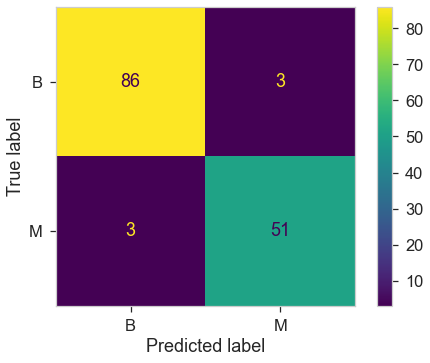

In [181]:
plt.figure()
plot_confusion_matrix(model_knn_3, X_test, y_test)
plt.grid(False)
plt.show()

In [182]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(86, 3, 3, 51)

### Métricas da matriz de confusão

A métrica especificidade que vamos utilizar não está disponível no sklearn, sem problemas, temos o conhecimento necessário para implementá-la: 

In [183]:
def especificidade(tn,fp):
    return tn/(tn+fp)

In [216]:
print("Acurácia:",accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred, pos_label="B"))
print("Especificidade:", especificidade(tn,fp))
print("Sensibilidade", recall_score(y_test, y_pred, pos_label="B"))
print(classification_report(y_test, y_pred, target_names=wisconsin["diagnosis"].unique()))

Acurácia: 0.958041958041958
Precisão: 0.9662921348314607
Especificidade: 0.9662921348314607
Sensibilidade 0.9662921348314607
              precision    recall  f1-score   support

           M       0.97      0.97      0.97        89
           B       0.94      0.94      0.94        54

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



### Estatística KS

A estatística de Kolmogorov-Smirnov (KS) mede a capacidade do classificador em distinguir entre as classes. Quanto maior a estatística KS, maior a separação entre as classes. Essa estatística é definida como o valor máximo da diferença entre as distribuições acumuladas das classes. É muito utilizada na modelagem de risco de crédito.

![title](data/KS_Example.png)

In [187]:
lb = LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)

def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic

ks_stat(y_test, y_pred)*100

91.07365792759052

### Curva ROC

In [188]:
model_knn_3.predict_proba([X_test.iloc[8].values])

array([[0.33333333, 0.66666667]])

limiar = 0.5
< 0.5 == 0
>= 0.5 == 1

0.1, 0.2, 0.3

Veja que um modelo de classificação binária geralmente é capaz de fornecer uma probabilidade da variável target ser = 1, e não apenas uma resposta fixa de 0 ou 1. Sendo assim, é possível definirmos diversos limiares, que:

- irão definir as labels da predição do algoritmo entre 0 e 1 (quanto mais próximo de 1 o limiar, mais valores serão preditos como 0; quanto mais próximo de 0 o limiar, mais valores serão preditos como 1);
- irão permitir calcular diversas taxas de (i) verdadeiro positivo e de (ii) falso positivo para cada nível de limiar, que serão justamente as duas colunas de dados necessárias para criar o gráfico da Curva ROC.

Dessa forma, a Curva ROC permite encontrar o limiar em que existe otmização da sensibilidade em função da especificidade. O ponto onde ocorre esta otimização é aquele que se encontra mais próximo do canto superior esquerdo do gráfico da curva ROC.


Fonte: https://cienciaenegocios.com/curva-roc-e-auc-em-machine-learning/

![title](data/ROC_curves.png)

D:\moise\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
D:\moise\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


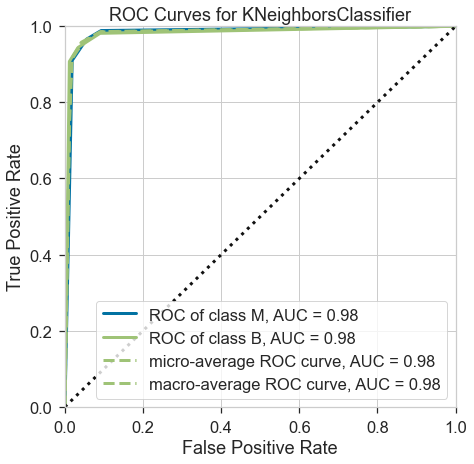

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [189]:
model_knn_3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

plt.figure(figsize = (7,7))
viz = ROCAUC(model_knn_3, classes=["M", "B"])
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

### Precisão - revocação

D:\moise\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


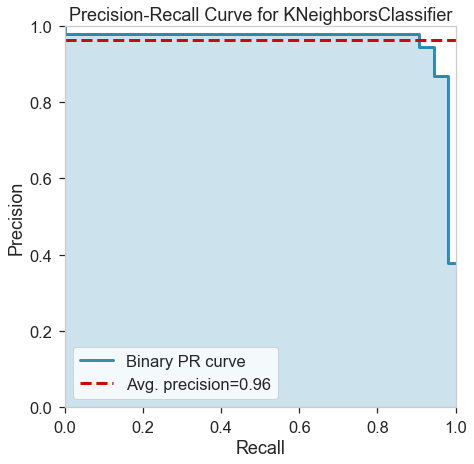

<AxesSubplot:title={'center':'Precision-Recall Curve for KNeighborsClassifier'}, xlabel='Recall', ylabel='Precision'>

In [190]:
plt.figure(figsize = (7,7))
viz = PrecisionRecallCurve(model_knn_3, classes=["M", "B"])
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

## Medidas mais indicadas no contexto de conjuntos de dados desbalanceados

In [191]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, class_sep=0.5, random_state=1)
counter = Counter(y)
counter

Counter({0: 9900, 1: 100})

In [192]:
dado_desbalanceado = pd.DataFrame(data = X, columns = ['x1', 'x2'])
dado_desbalanceado = pd.concat([dado_desbalanceado, pd.Series(y, name="y")], axis = 1)
dado_desbalanceado.head()

x1        x2  y
0 -0.277986  0.040207  0
1  0.847439  0.912824  0
2  0.037238 -0.127270  0
3  1.634462  0.904819  0
4  1.815827  0.856858  0

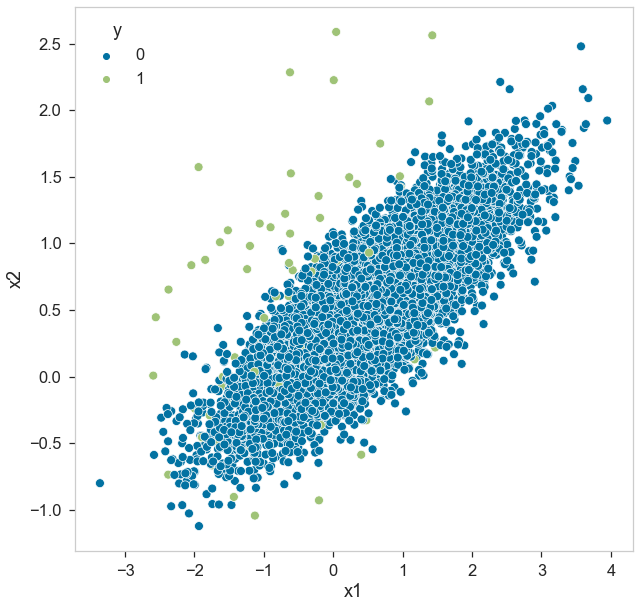

In [193]:
fig = plt.figure(figsize = (10,10))
ax = sns.scatterplot(x="x1", y="x2", hue="y", data=dado_desbalanceado, s=80)
ax.grid()

In [194]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.25, random_state=42)

In [195]:
model_knn_3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

model_knn_3.fit(X_train_2, y_train_2)

y_pred_2 = model_knn_3.predict(X_test_2)

In [196]:
accuracy_score(y_test_2,y_pred_2)

0.992

In [197]:
print(balanced_accuracy_score(y_test_2,y_pred_2))

0.5833333333333334


In [198]:
print(classification_report(y_test_2,y_pred_2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2476
           1       1.00      0.17      0.29        24

    accuracy                           0.99      2500
   macro avg       1.00      0.58      0.64      2500
weighted avg       0.99      0.99      0.99      2500



<Figure size 576x396 with 0 Axes>

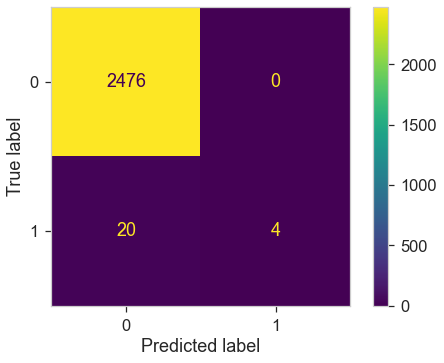

In [199]:
plt.figure()
plot_confusion_matrix(model_knn_3, X_test_2, y_test_2)
plt.grid(False)
plt.show()

In [200]:
tn2, fp2, fn2, tp2 = confusion_matrix(y_test_2, y_pred_2).ravel()
tn2, fp2, fn2, tp2

(2476, 0, 20, 4)

In [201]:
def gmean(especificidade, sensibilidade):
    return math.sqrt(especificidade*sensibilidade)

In [202]:
especificidade_2 = especificidade(tn2, fp2)
recall_2 = recall_score(y_test_2, y_pred_2)
gmean_calc = gmean(especificidade_2, recall_2)
gmean_calc

0.408248290463863

## Medidas de desempenho na tarefa de regressão

Um fato interessante é que, além das medidas de classificação, existem várias medidas avaliação de desempenho em regressão.

**Erro Absoluto Médio, em inglês, Mean absolute error (MAE)**:

\begin{equation}
        MAE = \frac{\sum_{i=1}^{n}|y_{i}-\hat{y}_{i}|}{n}
 \end{equation}

**Erro Quadrático Médio, em inglês, Mean squared error (MSE):**

\begin{equation}
        MSE = \frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2}{n}
 \end{equation}

**Erro Absoluto Percentual Médio, em inglês, Mean absolute percentage error (MAPE)**:

\begin{equation}
        MAPE = \frac{100}{n} \sum_{i=1}^{n} \frac{|y_{i}-\hat{y}_{i}|}{y_{i}}
 \end{equation}

**Coeficiente de Determinação, em inglês, R squared (r2)**

\begin{equation}
        r^2 = 1 - \frac{MSE}{Var(y)}
 \end{equation}

In [203]:
redWine = pd.read_csv("./data/winequality-red.csv", sep = ";")
redWine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [204]:
X_wine =redWine.drop(["quality"], axis = 1)
y_wine = redWine["quality"]

In [205]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_wine, y_wine, test_size=0.25, random_state=42)

In [206]:
model_reg3 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3, metric = 'euclidean'))

model_reg3.fit(X_train_reg, y_train_reg)

y_pred_reg = model_reg3.predict(X_test_reg)

In [207]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [208]:
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred_reg))
print("R2:", r2_score(y_test_reg, y_pred_reg))

MAE: 0.4975
MSE: 0.4625
MAPE: 9.122916666666676
R2: 0.25233644859813087


## Exemplo de avaliação de desempenho de ponta a ponta

Voltemos à base Breast Cancer

In [210]:
wisconsin  = pd.read_csv("./data/wisconsin.csv")
wisconsin.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [211]:
X_array = wisconsin.drop(["id", "diagnosis"], axis = 1)
y_array = wisconsin["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.25, random_state=42)

In [212]:
model_knn_3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
model_knn_5 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
model_knn_7 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=7))

In [213]:
performance_1 = cross_val_score(model_knn_3, X_train, y_train, cv=10, scoring = "balanced_accuracy")
performance_2 = cross_val_score(model_knn_5, X_train, y_train, cv=10, scoring = "balanced_accuracy")
performance_3 = cross_val_score(model_knn_7, X_train, y_train, cv=10, scoring = "balanced_accuracy")

In [214]:
print("Desempenho do modelo KNN 3 em 10-fold cv")
print(performance_1)
print("Performance média do KNN 3:", np.mean(performance_1))
print("Desvio padrão do KNN 3:", np.std(performance_1))
print("")
print("Desempenho do KNN 5 em 10-fold cv")
print(performance_2)
print("Performance média do KNN 5:",np.mean(performance_2))
print("Desvio padrão do KNN 5:",np.std(performance_2))
print("")
print("Desempenho do KNN 7 em 10-fold cv")
print(performance_3)
print("Performance média do KNN 7:",np.mean(performance_3))
print("Desvio padrão do KNN 7:",np.std(performance_3))

Desempenho do modelo KNN 3 em 10-fold cv
[0.9375     0.98148148 0.9375     0.91898148 0.96875    1.
 0.96666667 0.93333333 0.94951923 0.875     ]
Performance média do KNN 3: 0.9468732193732194
Desvio padrão do KNN 3: 0.03346686987317642

Desempenho do KNN 5 em 10-fold cv
[0.95023148 1.         0.96875    0.9375     0.96875    1.
 0.96666667 0.93333333 0.94951923 0.875     ]
Performance média do KNN 5: 0.9549750712250713
Desvio padrão do KNN 5: 0.034340503696567645

Desempenho do KNN 7 em 10-fold cv
[0.91898148 0.98148148 1.         0.9375     0.96875    1.
 0.93333333 0.93333333 0.94951923 0.875     ]
Performance média do KNN 7: 0.9497898860398859
Desvio padrão do KNN 7: 0.03693425223718357


In [215]:
model_knn_5.fit(X_train, y_train)
y_pred = model_knn_5.predict(X_test)
print(balanced_accuracy_score(y_test,y_pred))

0.9553682896379525
